In [1]:
import os
import pandas as pd

### Read Alignments of target_phonemes, target_graphemes and original_phonemes

In [2]:
# Read DART data
lrecDataDir = '../../astla-data/lrec-data'
pcuSegmFileDART = os.path.join(lrecDataDir, '4-pcu-segmentations-dart-preposttest.csv')
dart_df = pd.read_csv(pcuSegmFileDART, sep=';', converters = {'target_phones':eval,'target_pcus':eval, 'klankzuiver':eval, 'pcus_target_graph':eval,'pcus_target_phon':eval, 'pcus_orig_phon':eval})
dart_df.head(2)

,Unnamed: 0,filename,prompt,prompt_in_phonemes,phonTrans,error_cat,target_phones,target_pcus,klankzuiver,klankzuiver_pcus_total,word_klankzuiver,pcus_target_graph,pcus_target_phon,pcus_orig_phon
0,0,250ab45e-a370-4e97-94d6-0d12c2791a34_lesje,lesje,l E S @,l E S @,cor,"[l, E, S, @]","[l, e, sj, e]","[True, True, False, False]",2,False,"[l, e, sj, e]","[l, E, S, @]","[l, E, S, @]"
1,1,250ab45e-a370-4e97-94d6-0d12c2791a34_kijken,kijken,k EI k @,k EI k @,cor,"[k, EI, k, @, *]","[k, ij, k, e, n]","[True, True, True, False, False]",3,False,"[k, ij, k, e, n]","[k, EI, k, @, *]","[k, EI, k, @, *]"


### Print statistics

In [3]:
# 672 words, of which 308 are incorrect
print("OVERALL STATISTICS")
print("Length complete DF: ", len(dart_df))

print("\nSOUND PURE DART STATISTICS")

# Select sound pure (klankzuiver) words
dart_df_kz = dart_df[dart_df['word_klankzuiver'] == True]

# Print total items
print("Length transparent DF: ", len(dart_df_kz))

# Select sound pure (klankzuiver) words
correctDF = len(dart_df_kz[dart_df_kz['prompt_in_phonemes'] == dart_df_kz['phonTrans']])
print("... of which correct: ", correctDF, ' = ', correctDF/len(dart_df_kz) )

# Select sound pure (klankzuiver) words
incorrectDF = len(dart_df_kz[dart_df_kz['prompt_in_phonemes'] != dart_df_kz['phonTrans']])
print("... of which incorrect: ", incorrectDF, ' = ', incorrectDF/len(dart_df_kz) )

# Print different prompts
print("Different prompts: ", len(set(dart_df_kz["prompt"])))
print("Unique prompts: ", " ".join(sorted(list(set(dart_df_kz["prompt"])))))
# dart_df_kz["prompt"].value_counts()

OVERALL STATISTICS
Length complete DF:  672

SOUND PURE DART STATISTICS
Length transparent DF:  321
... of which correct:  207  =  0.6448598130841121
... of which incorrect:  114  =  0.35514018691588783
Different prompts:  51
Unique prompts:  bal boomstam buik deuk dof flits fop gat geit hout jaap jong juicht keelpijn klets koen kous lach lift lijn lus markt meetlat melk mug muis muur neef nicht proost reis saus schoen schraal schrift schrik schroef schroot schuur specht spierkracht sportpark sterk stoep strik toch vang vorst vuur warmst zwart


### Validation
Compare detected errors with manual annotations

In [4]:
def checkForMultipleAttempts(error_cat):
    if error_cat.find('Multi') != -1 or error_cat.find('-') != -1:
        return True
    else:
        return False

def generalizeNames(error_cat):
    # In case of multiple attempts, select last attempt
    if error_cat.find('-') != -1:
        error_cat = error_cat.split('-')[-1]

    if error_cat == 'prompt' or error_cat == 'pause' or error_cat == 'insMultiCor':
        return 'cor'
    if error_cat == 'insFinalN':
        return 'ins'
    if error_cat == 'insSjwaCons' or error_cat == 'sjwa':
        return 'ins'
    if error_cat == 'insMultiInc':
        return 'multi'
    if error_cat == '<unk>':
        return 'delWord'
    
    else:
        return error_cat

In [5]:
# Read manual DART data annotations
dart_ann_df = pd.read_csv('/vol/tensusers5/wharmsen/astla-data/lrec-data/5-dart-reading-selection-checked.csv')
annotationDict = dart_ann_df[['filename', 'error_cat']].set_index('filename')
annotationDict['multiple_attempts'] = annotationDict['error_cat'].apply(checkForMultipleAttempts)
annotationDict['error_cat'] = annotationDict['error_cat'].apply(generalizeNames)
#annotationDict.loc['250ab45e-a370-4e97-94d6-0d12c2791a34_lesje', 'error_cat']
annotationDict['error_cat'].value_counts()

error_cat
cor        447
multi       99
sub         62
ins         30
del         25
delWord      9
Name: count, dtype: int64

In [6]:
# Add manual error annotations to dataframe with automatically detected errors
errorCatList = []
multiAttList = []
for filenameID in dart_df['filename']:
    errorCatList.append(annotationDict.loc[filenameID, 'error_cat'])
    multiAttList.append(annotationDict.loc[filenameID, 'multiple_attempts'])
dart_df.loc[:, 'error_cat'] = errorCatList
dart_df.loc[:, 'multiple_attempts'] = multiAttList

In [7]:
#Determine unique error categories
unique_error_cats = list(dart_df['error_cat'].value_counts().index)
unique_error_cats

['cor', 'multi', 'sub', 'ins', 'del', 'delWord']

In [8]:
def annotateMultipleAttempts(row):
    return row['pcus_target_graph'][0] == "-" if len(row['pcus_target_graph'])>0 else False
    
def checkEqualLength(row):
    return len(row['pcus_target_graph']) == len(row['pcus_target_phon']) and len(row['pcus_target_graph']) == len(row['pcus_orig_phon'])

def annotatePhonemes(row):
    pcus_target_graph = row["pcus_target_graph"]
    pcus_target_phon = row["pcus_target_phon"]
    pcus_orig_phon = row["pcus_orig_phon"]
    
    annotationLabelList = []
    for idx, item in enumerate(pcus_target_graph):
        
        if pcus_target_phon[idx] == "*" and pcus_orig_phon[idx] != "*":
            annotationLabelList.append('ins')
        elif pcus_target_phon[idx] != "*" and pcus_orig_phon[idx] == "*":
            annotationLabelList.append('del')
        elif pcus_target_phon[idx] != pcus_orig_phon[idx]:
            annotationLabelList.append('sub')
        else:
            annotationLabelList.append('cor')
            
    return annotationLabelList

def annotateFinalAttempt(annotationList):
    # Remove initial insertions (representing incorrect attempt) from annotationList
    idxStartFinalAttempt = next((i for i, v in enumerate(annotationList) if v != 'ins'), -1)
    annotationList = annotationList[idxStartFinalAttempt:]

    if(len(annotationList) == 0):
        return 'delWord'
                                    
    insCount = annotationList.count('ins')
    delCount = annotationList.count('del')
    subCount = annotationList.count('sub')

    if insCount + delCount + subCount == 1:
        if insCount == 1:
            return 'ins'
        elif delCount == 1:
            return 'del'
        elif subCount == 1:
            return 'sub'
    elif insCount + delCount + subCount > 1:
        return 'multi'
    
    return 'cor'

# def annotateFinalAttempt2(annotationList):
#     # Remove initial insertions (representing incorrect attempt) from annotationList
#     idxStartFinalAttempt = next((i for i, v in enumerate(annotationList) if v != 'ins'), -1)
#     annotationList = annotationList[idxStartFinalAttempt:]

#     if(len(annotationList) == 0):
#         return 'delWord'
                                    
#     insCount = annotationList.count('ins')
#     delCount = annotationList.count('del')
#     subCount = annotationList.count('sub')

#     if insCount == 0  and delCount == 0 and subCount == 0:
#         return 'cor'
#     if insCount == 0  and delCount == 0 and subCount == 1:
#         return 'sub'
#     elif insCount == 0  and delCount == 1 and subCount == 0:
#         return 'del'
#     elif insCount == 1  and delCount == 0 and subCount == 0:
#         return 'ins'
#     else:
#         return 'multi'

In [9]:
# Add predicted error analysis
dart_df['pred_multiple_attempts'] = dart_df.apply(annotateMultipleAttempts, axis=1)
dart_df['pred_equalLength'] = dart_df.apply(checkEqualLength, axis=1)
dart_df['pred_phoneme_ann'] = dart_df.apply(annotatePhonemes, axis=1)
dart_df['pred_final_attempt_ann'] = dart_df['pred_phoneme_ann'].apply(annotateFinalAttempt)
# dart_df['pred_final_attempt_ann2'] = dart_df['pred_phoneme_ann'].apply(annotateFinalAttempt2)

dart_df.to_csv('validation_metrics_df.csv', sep=';', index=False)

In [10]:
dart_df[(dart_df['pred_final_attempt_ann'] != dart_df['error_cat']) & (dart_df['pred_multiple_attempts'] == False)]

,Unnamed: 0,filename,prompt,prompt_in_phonemes,phonTrans,error_cat,target_phones,target_pcus,klankzuiver,klankzuiver_pcus_total,word_klankzuiver,pcus_target_graph,pcus_target_phon,pcus_orig_phon,multiple_attempts,pred_multiple_attempts,pred_equalLength,pred_phoneme_ann,pred_final_attempt_ann
11,11,250ab45e-a370-4e97-94d6-0d12c2791a34_boomstam,boomstam,b o m s t A m,b o m s t A m,sub,"[b, o, m, s, t, A, m]","[b, oo, m, s, t, a, m]","[True, True, True, True, True, True, True]",7,True,"[b, oo, m, s, t, a, m]","[b, o, m, s, t, A, m]","[b, o, m, s, t, A, m]",False,False,True,"[cor, cor, cor, cor, cor, cor, cor]",cor
22,22,250ab45e-a370-4e97-94d6-0d12c2791a34_stuwdam,stuwdam,s t y w d A m,s t y w s t y d A m,del,"[s, t, y, w, d, A, m]","[s, t, u, w, d, a, m]","[True, True, False, True, True, True, True]",6,False,"[s, t, u, w, -, -, -, d, a, m]","[s, t, y, w, *, *, *, d, A, m]","[s, t, y, w, s, t, y, d, A, m]",True,False,True,"[cor, cor, cor, cor, ins, ins, ins, cor, cor, ...",multi
88,88,5946b407-24ac-46c2-a403-7d2c16cdf3cf_schrapen,schrapen,s x r a p @,s x A p s x A p @,del,"[s, x, r, a, p, @, *]","[s, ch, r, a, p, e, n]","[True, True, True, False, True, False, False]",4,False,"[s, ch, -, -, r, -, a, p, e, n]","[s, x, *, *, r, *, a, p, @, *]","[s, x, A, p, s, x, A, p, @, *]",True,False,True,"[cor, cor, ins, ins, sub, ins, sub, cor, cor, ...",multi
153,153,95ff418e-3cdb-49fb-b405-cbe57d9504cc_zanger,zanger,z A N @ r,z A N @,sub,"[z, A, N, @, r]","[z, a, ng, e, r]","[True, True, True, False, True]",4,False,"[z, a, ng, e, r]","[z, A, N, @, r]","[z, A, N, @, *]",False,False,True,"[cor, cor, cor, cor, del]",del
181,181,97a5cc9c-e38a-4b39-b2dc-972c950843a9_schraal,schraal,s x r a l,s x a r s x a l,del,"[s, x, r, a, l]","[s, ch, r, aa, l]","[True, True, True, True, True]",5,True,"[s, ch, -, r, -, -, aa, l]","[s, x, *, r, *, *, a, l]","[s, x, a, r, s, x, a, l]",True,False,True,"[cor, cor, ins, cor, ins, ins, cor, cor]",multi
204,204,ce5939b0-5c64-4767-8d78-bc714c93a3c3_deken,deken,d e k @,d e k @ n d E k @ n d E k @,sub,"[d, e, k, @, *]","[d, e, k, e, n]","[True, False, True, False, False]",2,False,"[d, e, -, -, -, -, -, -, -, -, -, -, k, e, n]","[d, e, *, *, *, *, *, *, *, *, *, *, k, @, *]","[d, e, k, @, n, d, E, k, @, n, d, E, k, @, *]",True,False,True,"[cor, cor, ins, ins, ins, ins, ins, ins, ins, ...",multi
372,372,2f16c46f-7980-4354-9c36-dbde32e64c38_neef,neef,n e f,n e v,cor,"[n, e, f]","[n, ee, f]","[True, True, True]",3,True,"[n, ee, f]","[n, e, f]","[n, e, v]",False,False,True,"[cor, cor, sub]",sub
601,601,aa809d8a-45d1-4cc0-a2c2-b40066d2849e_bo,bo,b O l,b O l,cor,"[b, o]","[b, o]","[True, False]",1,False,"[b, o]","[b, o]","[b, O]",False,False,True,"[cor, sub]",sub
608,608,aa809d8a-45d1-4cc0-a2c2-b40066d2849e_grapje,grapje,x r A p j @,G r A p j @,cor,"[x, r, A, p, j, @]","[g, r, a, p, j, e]","[True, True, True, True, True, False]",5,False,"[g, r, a, p, j, e]","[x, r, A, p, j, @]","[G, r, A, p, j, @]",False,False,True,"[sub, cor, cor, cor, cor, cor]",sub
634,634,d52f2fbc-588a-4002-8c02-772dabdbfc16_nieuwtje,nieuwtje,n i w t j @,n i w t j @ n i w j @,del,"[n, i, w, t, j, @]","[n, ieu, w, t, j, e]","[True, False, True, True, True, False]",4,False,"[n, ieu, w, t, -, -, -, -, -, j, e]","[n, i, w, t, *, *, *, *, *, j, @]","[n, i, w, t, j, @, n, i, w, j, @]",True,False,True,"[cor, cor, cor, cor, ins, ins, ins, ins, ins, ...",multi


In [11]:
dart_df[(dart_df["error_cat"]=='cor') & (dart_df["pred_final_attempt_ann"]=='multi')]

,Unnamed: 0,filename,prompt,prompt_in_phonemes,phonTrans,error_cat,target_phones,target_pcus,klankzuiver,klankzuiver_pcus_total,word_klankzuiver,pcus_target_graph,pcus_target_phon,pcus_orig_phon,multiple_attempts,pred_multiple_attempts,pred_equalLength,pred_phoneme_ann,pred_final_attempt_ann
635,635,d52f2fbc-588a-4002-8c02-772dabdbfc16_onze,onze,O n z @,O n z I n O n z O n z @ b @ d u l I k,cor,"[O, n, z, @]","[o, n, z, e]","[True, True, True, False]",3,False,"[-, -, -, -, -, -, -, -, o, n, z, -, -, e, -, ...","[*, *, *, *, *, *, *, *, O, n, z, *, *, @, *, ...","[O, n, z, I, n, O, n, z, O, n, z, @, b, @, d, ...",True,True,True,"[ins, ins, ins, ins, ins, ins, ins, ins, cor, ...",multi
647,647,d52f2fbc-588a-4002-8c02-772dabdbfc16_zanger,zanger,z a N E r,z a z A N E r,cor,"[z, A, N, @, r]","[z, a, ng, e, r]","[True, True, True, False, True]",4,False,"[z, a, -, -, ng, e, r]","[z, A, *, *, N, @, r]","[z, a, z, A, N, E, r]",True,False,True,"[cor, sub, ins, ins, cor, sub, cor]",multi


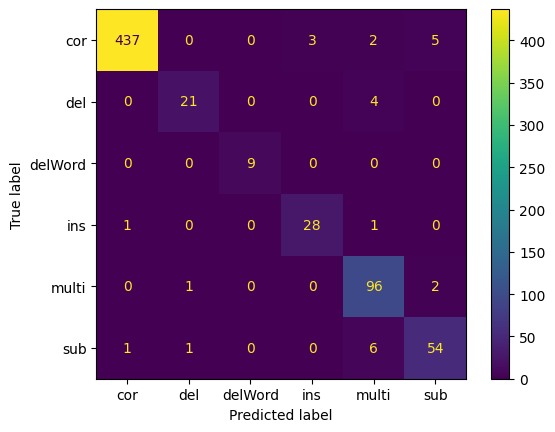

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt

labels = sorted(list(set(list(dart_df['error_cat'])+(list(dart_df['pred_final_attempt_ann'])))))

confusion_matrix = metrics.confusion_matrix(dart_df['error_cat'], dart_df['pred_final_attempt_ann'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=labels)

cm_display.plot()
plt.show()


In [13]:
print("MCC Error type")
metrics.matthews_corrcoef(dart_df['error_cat'], dart_df['pred_final_attempt_ann'])
#0.76485407809041

MCC Error type


0.9245270907294144

In [14]:
print("MCC Multiple Attempts")
metrics.matthews_corrcoef(list(dart_df['multiple_attempts']), list(dart_df['pred_multiple_attempts']))
#0.8779761904761905

MCC Multiple Attempts


0.8690224982429716

In [15]:
print(len(dart_df['error_cat']))

672


In [16]:
for unique_error_cat in unique_error_cats:

    # Validation of PCUs
    selectedWords = dart_df[dart_df['error_cat'] == unique_error_cat]
    print(unique_error_cat)
    print(len(selectedWords), '\n')

    for idx, row in selectedWords.iterrows():
        prompt = row["prompt"]
        promptPhon = row["prompt_in_phonemes"]
        origPhon = row["phonTrans"]
        pcus_target_graph = row["pcus_target_graph"]
        pcus_target_phon = row["pcus_target_phon"]
        pcus_orig_phon = row["pcus_orig_phon"]

        if(len(pcus_target_graph) == len(pcus_target_phon) and len(pcus_target_graph) == len(pcus_orig_phon)):
            print(prompt)
            print(promptPhon)
            print(origPhon)
            print("\t".join(pcus_target_graph))
            print("\t".join(pcus_target_phon))
            print("\t".join(pcus_orig_phon))
            print('\n')
        else:
            print("not equal length")


cor
447 

lesje
l E S @
l E S @
l	e	sj	e
l	E	S	@
l	E	S	@


kijken
k EI k @
k EI k @
k	ij	k	e	n
k	EI	k	@	*
k	EI	k	@	*


jaap
j a p
j a p
j	aa	p
j	a	p
j	a	p


sterk
s t E r k
s t E r k
s	t	e	r	k
s	t	E	r	k
s	t	E	r	k


bestaat
b @ s t a t
b @ s t a t
b	e	s	t	aa	t
b	@	s	t	a	t
b	@	s	t	a	t


denk
d E N k
d E N k
d	e	n	k
d	E	N	k
d	E	N	k


stoei
s t u j
s t u j
s	t	oe	i
s	t	u	j
s	t	u	j


kraken
k r a k @
k r A x k r A k @ n k r a k @
-	-	-	-	-	-	-	-	-	-	k	r	a	k	e	n
*	*	*	*	*	*	*	*	*	*	k	r	a	k	@	*
k	r	A	x	k	r	A	k	@	n	k	r	a	k	@	*


schrik
s x r I k
s x r I k
s	ch	r	i	k
s	x	r	I	k
s	x	r	I	k


warmst
w A r m s t
w A r m s t
w	a	r	m	s	t
w	A	r	m	s	t
w	A	r	m	s	t


jong
j O N
j O N
j	o	ng
j	O	N
j	O	N


web
w E p
w E p
w	e	b
w	E	p
w	E	p


zieke
z i k @
z i k @
z	ie	k	e
z	i	k	@
z	i	k	@


rechtsaf
r E x s A f
r r E x s A f
-	r	e	ch	t	s	a	f
*	r	E	x	*	s	A	f
r	r	E	x	*	s	A	f


spa
s p a
s p a
s	p	a
s	p	a
s	p	a


sterren
s t E r @
s t E r k s t E r @
-	-	-	-	-	s	t	e	rr	e	n
*	*	*	*	*	s	t	E	r	@	*
s	t	E	r	k	s	t	E	

In [17]:
#Switch to phoneme dataframe
pcu_matrix = []
for idx, row in dart_df_kz.iterrows():
    prompt = row["prompt"]
    pcus_target_graph = row["pcus_target_graph"]
    pcus_target_phon = row["pcus_target_phon"]
    pcus_orig_phon = row["pcus_orig_phon"]

    if(len(pcus_target_graph) == len(pcus_target_phon) and len(pcus_target_graph) == len(pcus_orig_phon)):
        for idx, item in enumerate(pcus_target_graph):
            pcu_matrix.append([pcus_target_graph[idx], pcus_target_phon[idx], pcus_orig_phon[idx], prompt,  pcus_target_phon[idx] == pcus_orig_phon[idx]])

dart_kz_pcu_df = pd.DataFrame(pcu_matrix, columns = ["pcu", "target_phon", "orig_phon", "prompt", "correct"])

In [18]:
dart_kz_pcu_df[dart_kz_pcu_df['correct'] == False]["pcu"].value_counts()

pcu
-     210
t      17
r      14
a      12
l      10
ch      8
s       7
k       6
ui      4
i       4
f       4
o       4
g       3
v       3
m       3
p       3
ng      2
n       2
ei      2
ee      1
oo      1
ou      1
uu      1
e       1
b       1
Name: count, dtype: int64

Print Latex table with PCU errors

In [19]:
unique_inc_pcus = list(dart_kz_pcu_df[dart_kz_pcu_df['correct'] == False]["pcu"].value_counts().index)
unique_inc_pcus

outputMatrix = []
for unique_pcu in unique_inc_pcus:
    df_selection = dart_kz_pcu_df[dart_kz_pcu_df['pcu'] == unique_pcu]
    total_length = len(df_selection)
    correct_count = len(df_selection[df_selection['correct'] == True])
    incorrect_count = len(df_selection[df_selection['correct'] == False])
    prompt_occurence = list(set(list(df_selection['prompt'])))
    unique_orig_phons = df_selection['orig_phon'].value_counts().index

    orig_pcu_string_list = []
    for unique_orig_phon in unique_orig_phons:
        orig_pcu_string_list.append(unique_orig_phon + " (" + str(round((len(df_selection[df_selection['orig_phon'] == unique_orig_phon])/total_length)*100, 2)) + ");")

    outputMatrix.append([unique_pcu, prompt_occurence, total_length, incorrect_count, round((incorrect_count/total_length)*100,2), len(orig_pcu_string_list)," ".join(orig_pcu_string_list)])

pd.DataFrame(outputMatrix, columns = ['pcu', 'prompts', 'count', 'inc_abs', 'inc_rel', 'count', 'substitutedby']).to_csv('hallo.csv')

In [33]:
reading_data = pd.DataFrame(outputMatrix, columns = ['pcu', 'prompts', 'count', 'inc_abs', 'inc_rel', 'count', 'substitutedby'])

array([['-', 100.0],
       ['t', 9.71],
       ['r', 10.07],
       ['a', 16.67],
       ['l', 12.82],
       ['ch', 9.3],
       ['s', 4.61],
       ['k', 6.98],
       ['ui', 23.53],
       ['i', 9.3],
       ['f', 8.51],
       ['o', 11.76],
       ['g', 15.79],
       ['v', 33.33],
       ['m', 4.76],
       ['p', 5.0],
       ['ng', 22.22],
       ['n', 8.33],
       ['ei', 11.11],
       ['ee', 5.88],
       ['oo', 6.25],
       ['ou', 20.0],
       ['uu', 6.25],
       ['e', 4.0],
       ['b', 4.55]], dtype=object)

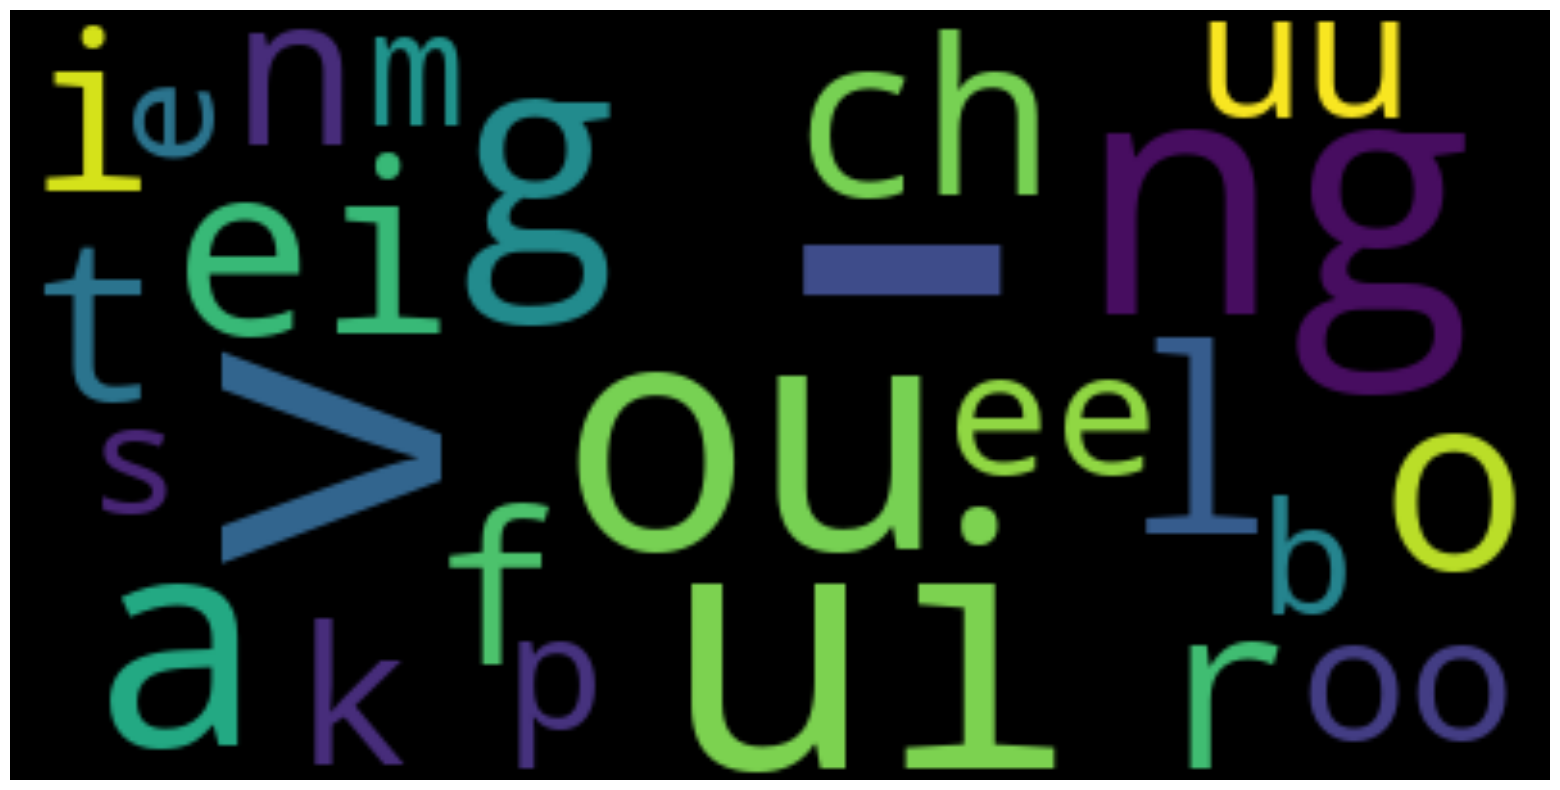

In [39]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

tuples = [tuple(x) for x in reading_data[['pcu', 'inc_rel']].values]
wordcloud = WordCloud().generate_from_frequencies(dict(tuples))

# # Create a word cloud image
# wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')

# # Generate a wordcloud
# wc.generate_from_frequencies("text text text haha loopt fietst")

# store to file
# wc.to_file("img/wine.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()